## Mini Project 1 
CE259 - Jessica Camacho, Christopher Tong, Catalina Vanoli 

**Modifying an existing local bus line to Bus Rapid Transit (BRT)**

The Geary transit corridor has one of the highest transit riderships in San Francisco. Current
service on Geary Boulevard has high scheduled frequencies, but is plagued by poor reliability
due to conflicts from operating in mixed traffic, high dwell times at bus stops, excessive signal delays and other difficulties.

In this project we will examine the current situation on Geary Blvd. during the evening rush, as well as the benefits that can be obtained through the introduction of BRT and a hierarchy of service.

**Route Characteristics**

The route consists of a 1.5 mile section in the CBD and 5 miles in the residential area. During a round trip, the bus currently stops at 84 relatively evenly spaced stops along the route including terminals at both ends (thus in each direction there are 41 stops plus the terminal) and the round trip of a bus is 120 min. 50% of this time is spent cruising, 25% loading and unloading(including loss time due to accelerating and decelerating), and 25% of the trip is caused by signal delay. We assume a fixed loss time of 10 sec per stop due to acceleration and deceleration, and that buses do not skip stops. Users take 4 times as long to board as to alight and we will assume that at each stop boarding and alighting movements occur in sequence. Users access bus stops by walking at a speed of 2 mph. Muni has budgeted 40 buses for the route, giving a headway of 3 minutes. 

**Standards for LOS**

We will analyze 3 types of users for this project:
1. Residential to Residential (R→R)
2. CBD to Residential (C→R)
3. Residential to CBD (R→C)

**Data**

The boarding and alighting demand density (PM rush) per hour per mile for service in both
directions is shown in the Mini Project description

In [121]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
import math

%matplotlib inline

L_c = 2*1.5
L_r = 2*5. #residential length

L = (L_c + L_r) #total length of round trip

stops_i = 84.

#in hours
time_roundtrip = 120. / 60

time_cruising = .5
time_load_unload = .25
signal_delay = .25

t_s = 10 / 3600. # time loss per stop
v_s = 2. #walk speed mph

# placeholder
alight_time_frac = 1.
board_time_frac = 4.

N = 40.

# demand

#pax per hr mile
cbd_boarding_to_lobos = 700
residential_boarding_to_lobos = 70
residential_boarding_to_TT = 240

cbd_alighting_to_TT = 600
residential_alighting_to_lobos = 280
residential_alighting_to_TT = 60

In [2]:
#total passengers served by finding total amount of boarding in the system per hour 
#and dividing by amount of buses

pax_board_lobos= L_c/2 * cbd_boarding_to_lobos + L_r * residential_boarding_to_lobos
pax_board_TT = L_r/2 * residential_boarding_to_TT

#pax per bus per hour
pax_board_hour= (pax_board_lobos + pax_board_TT)/ N

pax_alight_lobos= L_r/2 * residential_alighting_to_lobos
pax_alight_TT = L_c/2 * cbd_alighting_to_TT + L_r/2 *residential_alighting_to_TT

pax_alight_hour= (pax_alight_lobos + pax_alight_TT)/ N

print "passengers board: %s" % (pax_board_hour)
print "passengers alight: %s" % (pax_alight_hour)

passengers board: 65.0
passengers alight: 65.0


### Part 1

**Commercial speed:**

In [143]:
# commercial speed (mph)
commercial_speed = L / time_roundtrip

#cruising speed
cruising_speed = commercial_speed/(time_load_unload+signal_delay)

print "commercial speed: %s mph" % (commercial_speed)
print "cruising speed: %s mph" % (cruising_speed)

commercial speed: 6.5 mph
cruising speed: 13.0 mph


**Boarding and Alighting time:** 

In [15]:
accelerating_decelerating_loss_time = 10 / 3600.

# bus stops 84 times
total_acc_dec_losstime = stops_i* accelerating_decelerating_loss_time

# loading and alighting time
alight_time_per_passenger =(time_load_unload * time_roundtrip - total_acc_dec_losstime)/((pax_board_hour* board_time_frac + pax_alight_hour* alight_time_frac)*time_roundtrip)
board_time_per_passenger = alight_time_per_passenger * board_time_frac

print "passenger alight time: %s seconds (tau_a)" % (alight_time_per_passenger*3600)
print "passenger board time: %s seconds (tau_b)" % (board_time_per_passenger*3600)

passenger alight time: 1.47692307692 seconds (tau_a)
passenger board time: 5.90769230769 seconds (tau_b)


henceforth,

$$ 
\tau_a = 1.5 sec
\\
\tau_b = 6 sec
$$

But what is the **optimal stop spacing?** Since intial stop spacing is given and we know the relationship between cruising speed and v_max is: $$ v_c(s) =\frac{s}{t_s + \frac{s}{v_m}}$$

we know **max velocity** given we know the **initial stop spacing** is $ \frac{l} {stops_i}$ and $stops_i = 84 $

In [136]:
s = L / (stops_i)
print "current stop spacing: %s" %(s)
v_max = s/((s/cruising_speed)-t_s)
print "current max velocity: %s mph" %(v_max)

current stop spacing: 0.154761904762
current max velocity: 16.9565217391 mph


### $Riders_{R \rightarrow R}$

the **door to door** time is the **sum** of time related to:
* cruising
* accerlation & decleration lost time
* signal delay
* boarding and alighting of passengers ($\tau$)
* walking 
* waiting

below is the the equation of time as a function of length of travel ($l$) and stop spacing ($s$), when we only keep the terms that affect s:  

$$
T'(l,s) = \frac{s}{2v_s} + \frac{l}{v_cs} + \frac{10}{3600}\frac{l}{s}
$$

For users who are traveling $R \rightarrow R$ (without going to CBD),

we can estimate the average length of travel distance is: 


$$ 
l_r = \frac{5}{3}
$$

By numerically solving for the root, using just residential avg travel length:

stop spacing for Residential stops: [ 0.19246261]


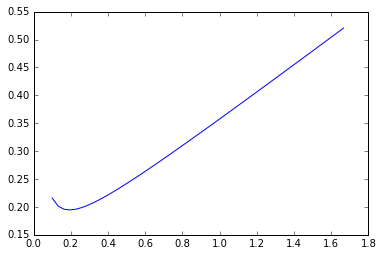

In [127]:
l_r= L_r/(2*3)


def v_c(s):
    return s/(t_s+s/v_max)

# this is not actual T, but only parts that affected stop spacing and trip length (T')
def T(s,l):
    return s/(2*v_s) + l/v_c(s) + t_s*l/s


solution = root(T,.01, l_r) # the second number here 
print "stop spacing for Residential stops: %s" % (solution.x)

s_RtoR = solution.x
plt.plot(np.linspace(.1,l_r),T(np.linspace(.1,l_r),l_r))
plt.show()

Alternatively we can solve in a **closed loop** equation. Given **EOQ** equation is: 

$$
z = Ax^\alpha + Bx^{-\beta}
$$

we can solve for s*:

$$
s^* = \frac{Bm}{An}^{\frac{1}{n+m}} = \sqrt{4t_sv_s[\bar l + \frac{13}{2(40)}]} $$

and so, $s_{r\rightarrow c}^*$ is:

In [125]:
l_r = 5/3. #residential average length
s_RtoR = math.sqrt(4 * t_s * v_s * (l_r + 13/80))

print "optimal stop spacing for residential riders: %s" %s_RtoR

optimal stop spacing for residential riders: 0.19245008973


### $Riders_{C \rightarrow R}$

Riders from CBD to Residential area has different avg travel length. By tracking the amount of boardings and alightings during one trip **westbound** from CBD to the ocean, we can graph an **input output diagram**. 

** See Desmos graph:
https://www.desmos.com/calculator/k3nniwwqj0
**

When calculating the area of the polygon and dividing by the amount of westbound boardings, 

$$Q_b = 700(1.5) + 70(5) = 1400 $$

$$\bar l_c = \frac{3412.5}{Q_b} = 2.44$$ 


We can solve $\bar l_c$ using weighted averages:

$$ 
l_c = \frac{l_a - .25l_r}{.75}$$

$$
l_c = 2.69$$

Using $l_c$ we plug into the EOQ equation to find stop spacing for $C \rightarrow R$ :

In [38]:
l_c = 2.69
s_CtoR = math.sqrt(4 * t_s * v_s * (l_c + 13/80))

print "optimal stop spacing for CBD riders: %s" %s_CtoR

optimal stop spacing for CBD riders: 0.244494944279


The percentage of $C \rightarrow R$ riders is:

In [123]:
Amount_CtoR = L_c/2  * cbd_boarding_to_lobos
Amount_RtoR1 = L_r/2 * (residential_boarding_to_lobos)
Amount_RtoR2= L_r/2 * residential_alighting_to_TT
Amount_RtoC = L_c/2 * cbd_alighting_to_TT

CBD_ratio = (Amount_CtoR+Amount_RtoC)/(Amount_RtoR1 + Amount_RtoR2 + Amount_CtoR+ Amount_RtoC)

print "Ratio of C->R transit: %s" % (CBD_ratio)

Ratio of C->R transit: 0.75


By weighting ratio of $C \rightarrow R$ users to $R \rightarrow R$ users, we can find a combined stop spacing at below:

$s^* = .75s_{C \rightarrow R} + .25s_{R\rightarrow R}$

In [132]:
s_star= round(CBD_ratio * s_CtoR + (1- CBD_ratio) * s_RtoR,3)

print "Optimal stop spacing is %s" % (s_star)

Optimal stop spacing is 0.231


So this means in the CBD zone, the optimal stop spacing absent of residential users is:

$s^*_{C \rightarrow R} = .245$

The optimal stop spacing in residential zone is dependent on the breakdown of CBD riders and Residential riders.

$s^*_{R \rightarrow R} = .231$

### Part 2

**Cruising time**

Travel time as a result of cruising should decrease by 50% whie travel time as a result of signal delay should decrease by 50%. Therefore, the breakdown of cycle time from part 1 is invalid. However, as we consider the time loading and unloading to be the same as before (due to the assumption that demand is consistent), we can calculate a new cycle time

In [171]:
signal_delay_time_2 = signal_delay*.5*time_roundtrip
cruising_time_2= time_cruising*time_roundtrip/1.5

print "%s min" % round((signal_delay_time_2 + cruising_time_2 + time_roundtrip*time_load_unload)*60) 

85.0 min


Assuming that the loss time due to acceleration and deceleration $t_s$ remains constant, the only variable affecting length would be distance travelled, which is not a function of cycle time.

### Part 3

In a heirarchy system, $C\rightarrow R$ users will board an express bus and transfer to a local bus at the express stop closest to their destination, $R \rightarrow C$ users will board a local bus and transfer to an express bus at the express stop closest to their origin. We assume all residential users will board the local bus (perhaps due to differences in pricing). 

Whereas in Part 1, we can assume all 40 buses operate the same route, in part 3, a certain percentage of buses operate as express buses while a certain percentage operate as local buses:

$$ 40 = N_l + N_r $$

#### Local Services

Bus stops for the local service are optimized for residential users. We can therefore optimize the **EOQ** with respect to the share of buses that are servicing the local route (out of 40 buses to serve both local and express):

$$s_L^*(N_l) = \sqrt{4t_sv_s(\bar l_r + \frac{10}{2N_l})}$$

#### Express

Express service will be given in the following equation:

$$ T_e(S_e,l) = walk_e + wait_e + cruise_e + accel_e + signal_e + wait_L + cruise_L$$

The included functions are below:

For $C \rightarrow R$ passengers: the one way walk time from CBD origin to the express stop. 
For $R \rightarrow C$ passengers: the one way walk time from the express stop to the CBD destination.

- $$ walk_E = \frac{S_E}{4v_s}$$

The wait time at the express stop:

- $$ wait_E = \frac{h_E}{2} = \frac{TT_E}{2N_E} = \frac{1}{2N_E}\Bigg[\frac{13(t_s + \frac{S_E}{V_{max}})}{S_E} + \frac{13t_s}{S_E} + \frac{30(13)}{13} + IVT_E(4\tau_aQ_{bE} + \tau_aQ_{aE})\Bigg]
$$

The cruise time while on express bus with cruise speed as a function of $S_E$, $t_s$ and $v_{max}$:

- $$cruise_E = \frac{\bar l_E(t_s + \frac{S_E}{V_{max}})}{S_E}$$

The acceleration and deceleration time of the express bus (10 seconds per stop):

- $$ accel_E = \frac{\bar l_Et_s}{S_E}\\$$

The signal delay of express bus: 

- $$ signal_E = \frac{30}{13}(\bar l_E) \\$$

Waiting for local bus transfer, which is half of the local service headway. At the same time the headway is round trip time divded by the number of local buses:

- $$ wait_L = \frac{h_L}{2}= \frac{TT_L(S_L^*)}{2(40-N_E)}$$

The last portion of the trip, which includes the cruise time of the local service and the walking time after alighting, calculated as an average length between express stops ($\frac{S_E}{4}$) divided by the average speed of the local service:

- $$ cruise_L =  \frac{S_E}{4V(\frac{S_E}{4})} = TT_L(\frac{S_E}{4}) $$

Boarding and alighting time (of the express bus):

- $$board_A = IVT_E\Big[4\tau_aQ_{bE} + \tau_aQ_{aE}\Big]\frac{\bar l_E}{L}$$

given $TT_L$ is:

$$TT_L(\frac{S_E}{4}) = \frac{\frac{S_E}{4}(t_s + \frac{S_L^*}{V_{max}})}{S_L^*} + \frac{\frac{S_E}{4}t_s}{S_E}+ \frac{30}{13}\frac{S_E}{4} + IVT_L\Big(4\tau_aQ_{bL} + \tau_aQ_{aL}\Big)
$$



#### Calculating Demand

The following are the boarding and alighting amounts for express and local bus (pax):

$$
Q_{bE} = \frac{100 x 1.5 + 600 x 1.5}{N_E}
$$

$$
Q_{aE} = \frac{(280-70)s + (240-60)s}{N_E}
$$

$$
Q_{bL} = \frac{70(s) +240(s)}{N_L}
$$

$$
Q_{aL} = \frac{280(s) +60(s)}{N_L}
$$

IVT are the corresponding invehicle times in express bus and in local bus. This includes the cruising time, signal delay, and boarding and alighting. 

### Appendix